0.16071428571428573
The Average Degree of the network is:  58.38557993730407
The Average Weighted Degree of the network is:  11716.385336102068
Hubs values: dict_items([(0, 0.00012107615008021933), (1, 6.442550101885205e-05), (2, 0.0010488364586806944), (3, 0.001143389842977332), (4, 4.602175046784876e-05), (5, 0.0012182450702149198), (6, 0.002894643712691917), (7, 0.0053677186358898985), (8, 0.0001324558159622026), (9, 0.00017952895041375988), (10, 0.0006812966246638956), (11, 0.00020039026149534675), (12, 0.0009466408222800314), (13, 0.0006232158448079768), (14, 0.0001404621428781455), (15, 0.0003038034937786029), (16, 0.0053941930152259865), (17, 0.00039858926559748625), (18, 0.0021586595990400193), (19, 0.005433243689457599), (20, 0.0026232679747391387), (21, 0.0002493543836468243), (22, 8.75019274829757e-05), (23, 0.00010332057685956247), (24, 7.776764938735443e-05), (25, 0.00029124442926735746), (26, 0.0001020085894888019), (27, 0.00037443123889894185), (28, 0.0001782026920390838

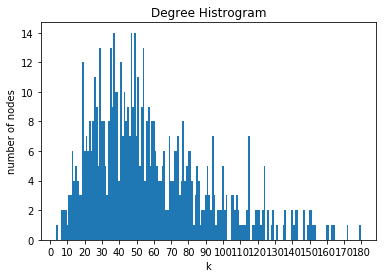

In [116]:
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import time
import collections
import community
import scipy.io
from networkx.algorithms.link_analysis import hits
import itertools
#import bct 

#1.Creation of Graph
def createGraph(file):
    G=nx.Graph()

    mat = scipy.io.loadmat(file) #matlab file containing an adjacency matrix for the coactivation 
    #network that includes the weights of each edge and the coordinates of each node in the brain

    content = list(mat.values()) #content[3] weights of the edges; content[4] coordinates
    #print(content[3])
    G = nx.from_numpy_matrix(content[3])
    print(G.edges[0,1]['weight'])
    return G

#Degree analysis

#Average Degree
def averageDegree(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    av_degree = (2*E)/N
    return av_degree

#Average Weighted Degree:
def averageWeightedDegree(G):
    N = G.number_of_nodes()
    weightedDegree = np.zeros(N)
    #we start by computing the weighted degree for each node (sum of weights of the edges linked to that node        
    for u, v, w in G.edges(data = 'weight'):
        weightedDegree[u] += w
        weightedDegree[v] += v
    #print(weightedDegree)
    av_weightedDegree = sum(weightedDegree)/N
    return av_weightedDegree

#Degree Distribution
def degreeDistribution(G):
    #get sequence of the degrees of each node ordered 
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    #print("Degree sequence", degree_sequence)
    degreeCount = collections.Counter(degree_sequence) #gives a list that as the degree and number of times it repeats
    #print("Degree count", degreeCount)
    degree, count = zip(*degreeCount.items()) #to obtain arguments separated 
    #print(degree)
    
    plt.figure() 
    plt.bar(degree, count, width=1) #plot histogram
    plt.xticks(np.arange(0, 190, 10))
    plt.title("Degree Histrogram")
    plt.ylabel("number of nodes")
    plt.xlabel("k")

#put histogram in range 10 by 10 - equal to the one in the article    

#determine hubs in network to verify its location in the brain
def hubsComputation(G):
    #with hits algorithm we can determine two values for each node: hubs and authorities. Hubs estimates the node 
    #value based on outgoing links and authorities estimates the node value based on the incoming links
    
    #we can determine each node's hub value, that estimates the value of its links to other pages, to select the most
    #important nodes
    
    #http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture4/lecture4.html
    
    hubs, authorities = hits(G)
    #print("Hubs values:", hubs.items())
    #print("Authorities values:", authorities)
    #these values will be approximately equivalent since we have an undirected graph
    
    hubs_sequence = sorted(hubs.items(),key=itemgetter(1),reverse=True)
    #print("Hubs sequence:", hubs_sequence)
    
    top_ten_hubs_hits = [] 
  
    for i in range(0, 10):  #we want to select top 10 nodes in terms of hub value
        max = 0
        node = 0  
        for j in range(len(hubs_sequence)):      
            if hubs_sequence[j][1] > max: 
                pair = hubs_sequence[j]
                max = hubs_sequence[j][1];
                node = hubs_sequence[j][0]
        
        hubs_sequence.remove(pair);
        top_ten_hubs_hits.append(node) 
          
    print("Top ten nodes, considering hub value:", top_ten_hubs_hits) 
    
    #we can also select the nodes with highest degree since they will be hubs (a lot of links to other links)
    
    degrees = G.degree() #get list with pairs (node, degree)
    #print("Degrees:", degrees)
    degree_sequence = sorted(G.degree(),key=itemgetter(1),reverse=True) #get list with pairs (node, degree) sorted
    #by degree
    #print("Degree sequence:", degree_sequence)
    
    top_ten_hubs_degree = [] 
  
    for i in range(0, 10):  #we want to select top 10 nodes in terms of hub value
        max = 0
        node = 0  
        pair = ()
        for j in range(len(degree_sequence)):      
            if degree_sequence[j][1] > max: 
                pair = degree_sequence[j]
                max = degree_sequence[j][1];
                node = degree_sequence[j][0]
        #print("max:", max)
        #print("node:", node)
        degree_sequence.remove(pair);
        top_ten_hubs_degree.append(node) 
          
    print("Top ten hubs, considering degree:", top_ten_hubs_degree)

G = createGraph('Coactivation_matrix.mat')

av_degree = averageDegree(G)
print("The Average Degree of the network is: ", av_degree)

av_w_degree = averageWeightedDegree(G)
print("The Average Weighted Degree of the network is: ", av_w_degree)

degreeDistribution(G)

hubsComputation(G)

#using R function mni_to_region_name(x,y,z) we can obtain the region where these coordinates are located 
#when the mni coordinate do NOT have a corresponding region -> output closest region and distance to it

#considering the ten hubs, in terms of hits algorithm, we have that:

# 483 - (-2.606837606837601, 12, 55.273504273504270) - "Supp_Motor_Area_L"
# 331 - (-41.091445427728615, -44.525073746312685, 52.147492625368730) - "Parietal_Inf_L"
# 486 - (-4.552301255230120, 17.054393305439334, 47.849372384937240) - "Supp_Motor_Area_L"
# 401 - (-48.193050193050200, 7.088803088803076, 32.308880308880305) - "Precentral_L"
# 236 - (37.201581027667984, 23.873517786561250, 0.197628458498031) - "Insula_R"
# 492 - (7.942446043165461, 14.050359712230204, 49.992805755395680) - "Supp_Motor_Area_R"
# 39 - (-51.270886075949360, 12.126582278481010, 24.997468354430380) - "Frontal_Inf_Oper_L"
# 357 - (-30.687074829931973, -61.748299319727890, 53.251700680272110) - "Parietal_Sup_L"
# 231 - (-31.523809523809520, 23.311355311355300, 1.384615384615387) - "Insula_L"
# 417 - (50.068965517241380, 7.400000000000006, 40.289655172413790) - "Precentral_R"

#considering the ten hubs, in terms of degree, we have that: (8 of the hubs are the same)

# 331 - (-41.091445427728615, -44.525073746312685, 52.147492625368730) - "Parietal_Inf_L"
# 483 - (-2.606837606837601, 12, 55.273504273504270) - "Supp_Motor_Area_L"
# 231 - (-31.523809523809520, 23.311355311355300, 1.384615384615387) - "Insula_L"
# 417 - (50.068965517241380, 7.400000000000006, 40.289655172413790) - "Precentral_R"
# 486 - (-4.552301255230120, 17.054393305439334, 47.849372384937240) - "Supp_Motor_Area_L"
# 236 - (37.201581027667984, 23.873517786561250, 0.197628458498031) - "Insula_R"
# 357 - (-30.687074829931973, -61.748299319727890, 53.251700680272110) - "Parietal_Sup_L"
# 495 - (6.018018018018012, 9.360360360360374, 59.297297297297290) - "Supp_Motor_Area_R"
# 351 - (-24.787003610108300, -64.057761732851990, 56.772563176895320) - "Parietal_Sup_L"
# 401 - (-48.193050193050200, 7.088803088803076, 32.308880308880305) - "Precentral_L"


print("Finish")

Modularity of the network: 0.467445852922999


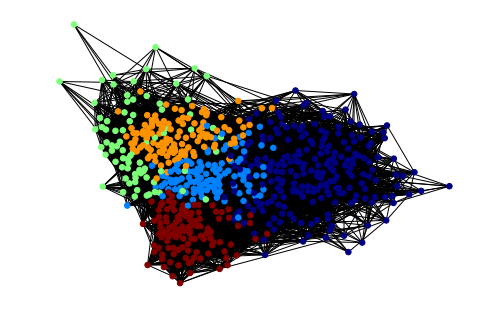

Number of communities: 5
[219 113  78 116 112]


In [85]:
#3.Study of Communities in the Coactivation network

# Modularity is one measure of the structure of networks or graphs. It was designed to measure the strength of 
#division of a network into modules (also called groups, clusters or communities). 
#Networks with high modularity have dense connections between the nodes within modules but sparse connections 
#between nodes in different modules.

def communities(G):
    #first compute the best partition
    part = community.best_partition(G) #returns dictionary assign a community (integer) to each node
    mod = community.modularity(part, G) #compute modularity
    print("Modularity of the network:", mod)
    
    # Plot, color nodes using community structure
    values = [part.get(node) for node in G.nodes()] #creates a list with the community number for each node in the 
    #order that appears in G.nodes()
        
    # it will use those community numbers to determine the color of the nodes. 
    #All nodes which have been assigned to the same community will be given the same color.
    nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False, dpi=1200)
    plt.figure(figsize=(100, 100))
    plt.show()
    
    #determine number of nodes in each community
    number_communities = max(values)+1
    print("Number of communities:", number_communities)
    count_communities = np.zeros((number_communities,), dtype=int)
    for key,value in part.items():
        count_communities[value] += 1
    
    print(count_communities)


#Não alterei nada do código ainda!
communities(G)

In [ ]:
betweeness=bct.betweenness_wei(G)
